# CubicGalileonEmu

> GP emulator for boost factor in cubic Galileon gravity model

Modified Gravity emulator for boost in the dark matter power spectra

## Install

(not installable yet)
```sh
pip install CubicGalileonEmu
```

## Basic rundown

### A few imports 

In [ ]:
from CubicGalileonEmu.load import *
from CubicGalileonEmu.viz import *
from CubicGalileonEmu.pca import *
from CubicGalileonEmu.gp import *
from CubicGalileonEmu.emu import *
from CubicGalileonEmu.mcmc import *

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

### Loading files

In [ ]:
Bk_all, k_all, z_all = load_boost_training()
p_all = load_params()

exclude = 35
Bk_all = np.delete(Bk_all, exclude, axis=0)
p_all = np.delete(p_all, exclude, axis=0)

### A few plotting routines

#### Experimental design

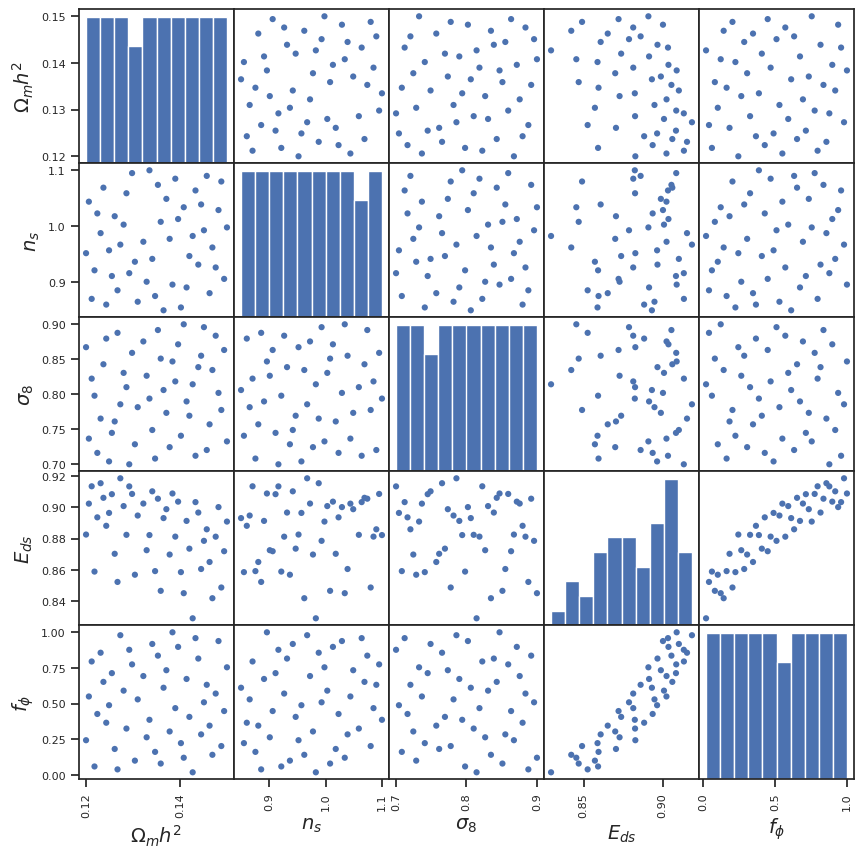

In [ ]:
df_train_a = pd.DataFrame(p_all, columns=PARAM_NAME)
colors = ['b']*p_all.shape[0]
# colors = ['b']*num_sims + ['r']*num_sims_test
plot_scatter_matrix(df_train_a, colors);

#### Boost metrics colored by cosmology parameters

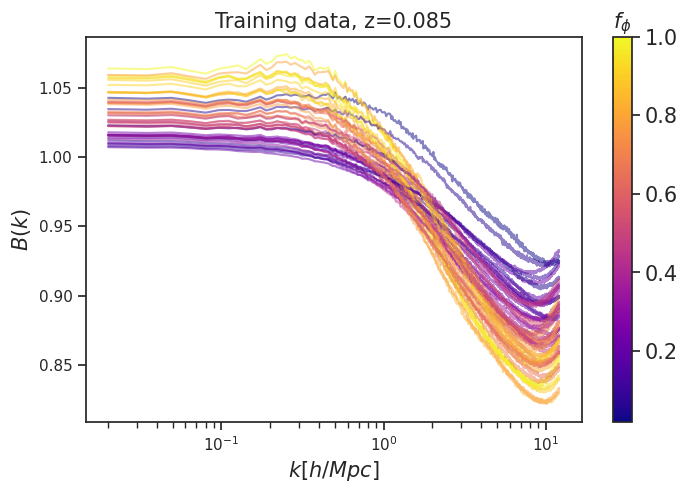

In [ ]:
color_by_index = 4
z_index = 0

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

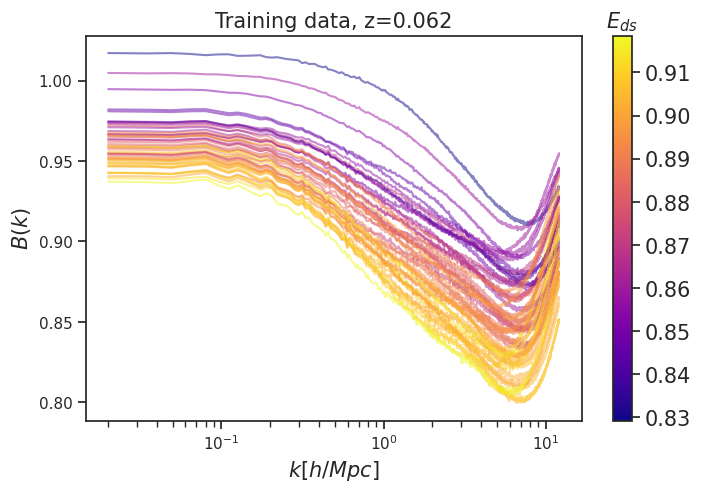

In [ ]:
color_by_index = 3
z_index = 21

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data, z=' + str(z_all[z_index]), 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index]);

### Training involves: PCA, GP fitting.  

In [ ]:
## Data prep
z_index = 1
y_vals = Bk_all[:, z_index, :]
# y_ind = np.arange(0, y_vals.shape[1])
y_ind = k_all

# Train-test split
test_indices = [0, 14, 35]
input_params= p_all[test_indices]
target_vals = Bk_all[:, z_index, :][test_indices]

train_indices = [i for i in  np.arange(49) if i not in test_indices] 
p_all_train = p_all[train_indices]
y_vals_train = Bk_all[:, z_index, :][train_indices]

In [ ]:
sepia_data = sepia_data_format(p_all_train, y_vals_train, y_ind)
print(sepia_data)
model_filename = '../CubicGalileonEmu/model/multivariate_model_z_index' + str(z_index) 

sepia_model = do_pca(sepia_data, exp_variance=0.95)
sepia_model = do_gp_train(sepia_model, model_filename)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    46 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Step size tuning: 100%|██████████| 50/50 [00:06<00:00,  7.33it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.36857465 0.27579324]
 [0.62080177 0.48199099]
 [0.08869402 0.0545149 ]
 [0.22954087 0.24228404]
 [0.86711195 0.18501455]
 [0.04937151 1.61668292]]
lamUz
[[0.67501053 0.95104611]]
lamWs
[[4892.56331012 5318.25062629]]
lamWOs
[[4.49501946]]


MCMC sampling: 100%|██████████| 1000/1000 [00:06<00:00, 154.77it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index1.pkl


### Load existing model

In [ ]:
sepia_model = gp_load(sepia_model, model_filename)

No thetas to plot


(None, <Figure size 1000x750 with 5 Axes>)

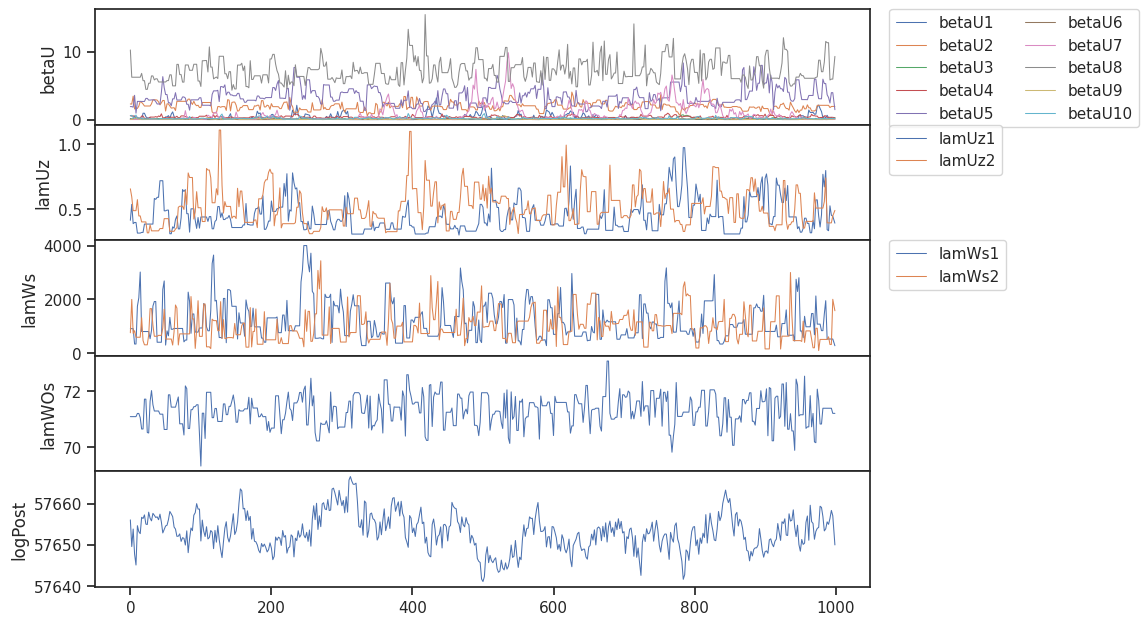

In [ ]:
plot_train_diagnostics(sepia_model)

### Single-redshift emulation for new cosmological parameters

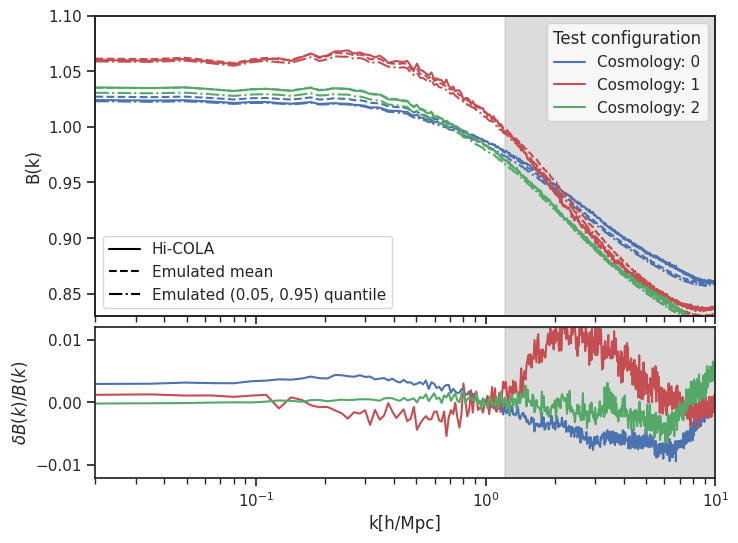

In [ ]:
pred_mean, pred_quant = emulate(sepia_model, input_params)
validation_plot(k_all, target_vals, pred_mean, pred_quant);

### Sensitivity analysis from the emulator 

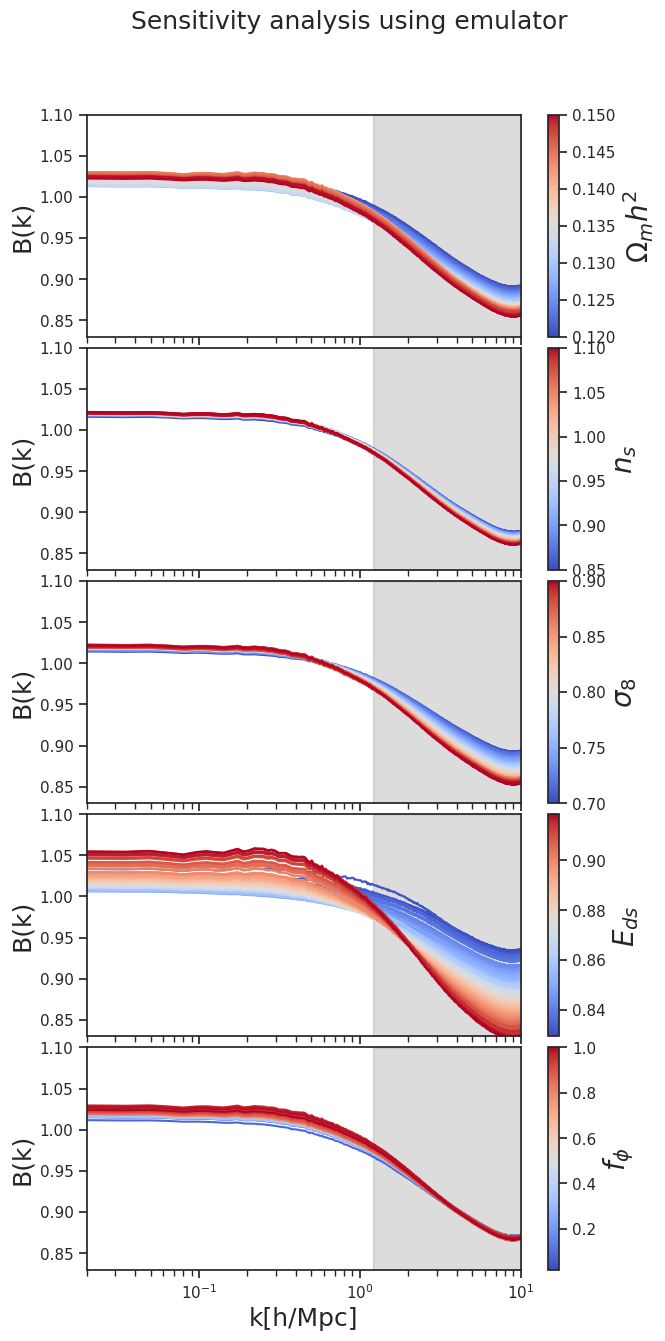

In [ ]:
f = sensitivity_plot(k_all, p_all, sepia_model, emulate, PARAM_NAME)

### Multi-redshift emulation (not part of the emulator yet)

#### Train all the models

In [ ]:
do_gp_train_multiple(model_dir='../CubicGalileonEmu/model/', 
                     p_train_all = p_all[train_indices],
                     y_vals_all = Bk_all[train_indices],
                     y_ind_all = k_all,
                     z_index_range=np.arange(48, 51))

Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Step size tuning: 100%|██████████| 50/50 [00:06<00:00,  7.24it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.84962983 0.55061513]
 [0.53522225 0.62719238]
 [0.09469166 0.14635733]
 [0.16016943 0.32264786]
 [0.88338879 0.83410636]
 [0.13976631 0.05598826]]
lamUz
[[0.72856069 0.75947313]]
lamWs
[[2933.09376652 4030.53129834]]
lamWOs
[[0.00016946]]


MCMC sampling: 100%|██████████| 1000/1000 [00:06<00:00, 148.92it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index48.pkl
Training complete for snapshot 48
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|██████████| 50/50 [00:06<00:00,  7.29it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[0.09376756 0.29258074]
 [0.58341226 0.75033873]
 [0.10396515 0.09890054]
 [0.15642069 0.35463913]
 [0.67167469 0.84740975]
 [0.14178743 0.07358285]]
lamUz
[[0.70251699 0.4604869 ]]
lamWs
[[2603.41806256 5094.59259526]]
lamWOs
[[0.00392802]]


MCMC sampling: 100%|██████████| 1000/1000 [00:06<00:00, 148.72it/s]


Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index49.pkl
Training complete for snapshot 49
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Starting tune_step_sizes...
Default step sizes:
betaU
[[0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]
 [0.1 0.1]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]


Step size tuning: 100%|██████████| 50/50 [00:06<00:00,  7.29it/s]


Done with tune_step_size.
Selected step sizes:
betaU
[[1.24347744 0.50287739]
 [0.60277981 0.24753287]
 [0.056739   0.10408657]
 [0.10230067 0.4958362 ]
 [0.7752516  1.45344266]
 [0.05196823 0.41456802]]
lamUz
[[1.19891953 0.70002516]]
lamWs
[[4301.73952038 1051.56869345]]
lamWOs
[[0.09814525]]


MCMC sampling: 100%|██████████| 1000/1000 [00:06<00:00, 154.88it/s]

Model saved to ../CubicGalileonEmu/model/multivariate_model_z_index50.pkl
Training complete for snapshot 50
Model saved at ../CubicGalileonEmu/model/
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*


In [ ]:
sepia_model_list = load_model_multiple(model_dir='../CubicGalileonEmu/model/', 
                                       p_train_all=p_all,
                                       y_vals_all=Bk_all,
                                       y_ind_all=y_ind,
                                       z_index_range=range(51), 
                                       sepia_model_i=sepia_model)

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (number of simulated data)
p  =     1 (number of inputs)
q  =     5 (number of additional simulation inputs)
pu NOT SET (transformed response dimension); call method create_K_basis 

This SepiaData instance implies the following:
This is a simulator (eta)-only model, y dimension 768
m  =    49 (nu

In [ ]:
input_params0 = input_params[0]
z_inputs = 0.1234
input_params_and_redshift = np.append(input_params0, z_inputs)

In [ ]:
emulated_with_redshift, emulated_with_redshift_err = emu_redshift(input_params_and_redshift[np.newaxis, :], sepia_model_list, z_all)

(1, 5)
[0.1234]
SNAP ID:  2 3
IP:  (1, 5)


<matplotlib.legend.Legend>

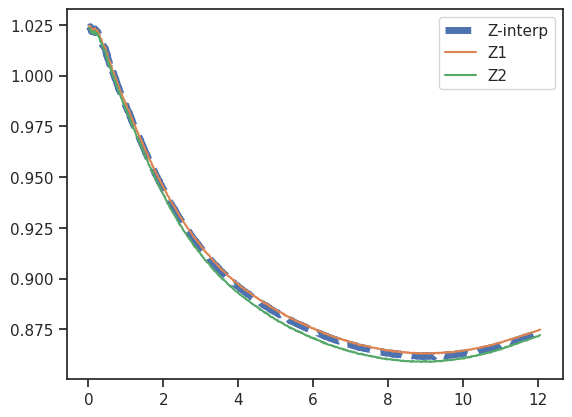

In [ ]:
plt.plot(k_all, emulated_with_redshift[:, 0], label='Z-interp', lw=5, ls='--')
plt.plot(k_all, emulate(sepia_model_list[2], input_params_and_redshift[:-1])[0], label='Z1')
plt.plot(k_all, emulate(sepia_model_list[3], input_params_and_redshift[:-1])[0], label='Z2')
plt.legend()
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))
# plt.plot(k_all, emulate(sepia_model_list[0], input_params))

### Parameter inference using the emulator (not implemented yet)

In [ ]:
ndim = 5
nwalkers = 50  # 500
nrun_burn = 100  # 300
nrun = 1000  # 700

In [ ]:
target_indx = 23
z_index = 1
L = 128

x_grid = k_all
x = k_all
y = Bk_all[:, z_index, :][target_indx]
yerr = np.sqrt( Bk_all[:, z_index, :][target_indx] *(L**3) )/(L**3)
params_calib = p_all[target_indx][:, np.newaxis].T

In [ ]:
allMax = np.max(p_all, axis = 0)
allMin = np.min(p_all, axis = 0)

param1 = [PARAM_NAME[0], params_calib[0][0], allMin[0], allMax[0]] # Actual 0.119
param2 = [PARAM_NAME[1], params_calib[0][1], allMin[1], allMax[1]]
param3 = [PARAM_NAME[2], params_calib[0][2], allMin[2], allMax[2]]
param4 = [PARAM_NAME[3], params_calib[0][3], allMin[3], allMax[2]]
param5 = [PARAM_NAME[3], params_calib[0][3], allMin[4], allMax[4]]

params_list = [param1, param2, param3, param4, param5]
theta = np.array([0.1218, 0.9214, 0.798, 0.85906746, 0.06122, 0.01])

In [ ]:
ln_prob(theta, params_list, x_grid, sepia_model_list, z_all, x_grid, y, yerr)

(1, 5)
[0.01]
SNAP ID:  14 15
IP:  (1, 5)


6.994294475631643